In [10]:
# Install dependencies
!pip install timm torch torchvision pandas matplotlib seaborn scikit-learn tqdm

# Import libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import time
import timm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


=== DISTRIBUSI KELAS ===
label
nasi_goreng    234
rendang        227
bakso          220
gado_gado      215
soto_ayam      212
Name: count, dtype: int64


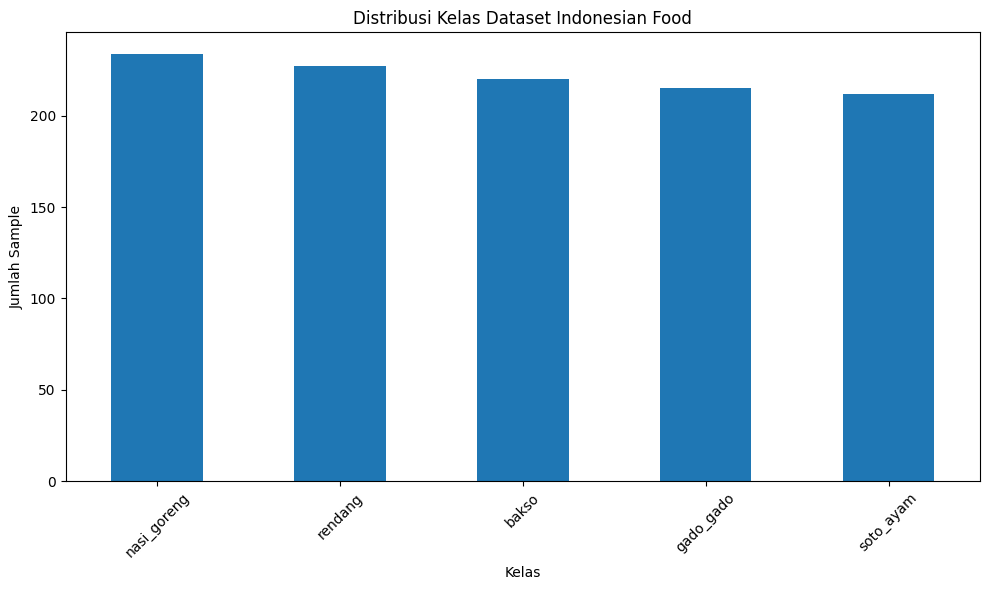


Total samples: 1108
Jumlah kelas: 5
Kelas: ['nasi_goreng', 'rendang', 'bakso', 'gado_gado', 'soto_ayam']


In [11]:
# Load data
base_path = "/content/drive/MyDrive/DatasetMakanan"
train_csv = pd.read_csv(f"{base_path}/train.csv")

# 1. Cek distribusi kelas (WAJIB untuk laporan)
print("=== DISTRIBUSI KELAS ===")
class_distribution = train_csv['label'].value_counts()
print(class_distribution)

# Visualisasi distribusi
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribusi Kelas Dataset Indonesian Food')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Cek sample data
print(f"\nTotal samples: {len(train_csv)}")
print(f"Jumlah kelas: {len(class_distribution)}")
print(f"Kelas: {class_distribution.index.tolist()}")

In [12]:
# Transformasi (TANPA AUGMENTASI)
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset Class
class FoodDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.classes = dataframe['label'].unique()
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['filename']
        label = self.dataframe.iloc[idx]['label']

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.class_to_idx[label]

    def get_class_names(self):
        return self.classes.tolist()

# Split data
train_df, val_df = train_test_split(
    train_csv, test_size=0.2, random_state=42, stratify=train_csv['label']
)

print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

# Create datasets
train_dataset = FoodDataset(train_df, f"{base_path}/train", transform=transform)
val_dataset = FoodDataset(val_df, f"{base_path}/train", transform=transform)

# DataLoaders
BATCH_SIZE = 16  # Sesuaikan dengan kemampuan laptop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.get_class_names()
print(f"Class names: {class_names}")

Train samples: 886
Val samples: 222
Class names: ['soto_ayam', 'nasi_goreng', 'bakso', 'gado_gado', 'rendang']


In [13]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable, total - trainable

def train_model(model, train_loader, val_loader, model_name, epochs=10, lr=2e-5):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    # Tracking
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_acc = 0
    best_model = None

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict().copy()

    # Load best model
    model.load_state_dict(best_model)

    return model, {
        'train_losses': train_losses, 'val_losses': val_losses,
        'train_accs': train_accs, 'val_accs': val_accs,
        'best_val_acc': best_acc, 'all_preds': all_preds, 'all_labels': all_labels
    }

In [14]:
print("=== VISION TRANSFORMER (ViT) - RINGAN ===")

# Load model ringan dari timm
vit_model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=len(class_names))

# FREEZE untuk mempercepat training (opsional)
for name, param in vit_model.named_parameters():
    if 'head' not in name:  # Hanya train classifier head
        param.requires_grad = False

# Hitung parameter
total_params, trainable_params, non_trainable = count_parameters(vit_model)
print(f"ViT Parameters - Total: {total_params:,}, Trainable: {trainable_params:,}, Non-trainable: {non_trainable:,}")

# Training
vit_model, vit_history = train_model(
    vit_model, train_loader, val_loader, "ViT-Tiny",
    epochs=5, lr=1e-4  # Epochs sedikit untuk testing
)

=== VISION TRANSFORMER (ViT) - RINGAN ===
ViT Parameters - Total: 5,525,381, Trainable: 965, Non-trainable: 5,524,416


Epoch 1/5: 100%|██████████| 56/56 [01:31<00:00,  1.64s/it]


Epoch 1: Train Loss: 1.7619, Train Acc: 32.73% | Val Loss: 2.1198, Val Acc: 9.91%


Epoch 2/5: 100%|██████████| 56/56 [01:27<00:00,  1.56s/it]


Epoch 2: Train Loss: 1.4247, Train Acc: 42.89% | Val Loss: 2.1432, Val Acc: 11.71%


Epoch 3/5: 100%|██████████| 56/56 [01:26<00:00,  1.54s/it]


Epoch 3: Train Loss: 1.2184, Train Acc: 54.40% | Val Loss: 2.1946, Val Acc: 12.61%


Epoch 4/5: 100%|██████████| 56/56 [01:26<00:00,  1.54s/it]


Epoch 4: Train Loss: 1.0570, Train Acc: 61.96% | Val Loss: 2.2709, Val Acc: 17.57%


Epoch 5/5: 100%|██████████| 56/56 [01:25<00:00,  1.53s/it]


Epoch 5: Train Loss: 0.9433, Train Acc: 68.28% | Val Loss: 2.3466, Val Acc: 18.92%


In [15]:
print("=== DEIT - RINGAN ===")

# Load model ringan
deit_model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(class_names))

# FREEZE untuk mempercepat training
for name, param in deit_model.named_parameters():
    if 'head' not in name:
        param.requires_grad = False

# Hitung parameter
total_params, trainable_params, non_trainable = count_parameters(deit_model)
print(f"DeiT Parameters - Total: {total_params:,}, Trainable: {trainable_params:,}, Non-trainable: {non_trainable:,}")

# Training
deit_model, deit_history = train_model(
    deit_model, train_loader, val_loader, "DeiT-Tiny",
    epochs=5, lr=1e-4
)

=== DEIT - RINGAN ===


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

DeiT Parameters - Total: 5,525,381, Trainable: 965, Non-trainable: 5,524,416


Epoch 1/5: 100%|██████████| 56/56 [01:34<00:00,  1.69s/it]


Epoch 1: Train Loss: 1.6660, Train Acc: 20.54% | Val Loss: 1.6372, Val Acc: 21.17%


Epoch 2/5: 100%|██████████| 56/56 [01:26<00:00,  1.54s/it]


Epoch 2: Train Loss: 1.4262, Train Acc: 41.65% | Val Loss: 1.6933, Val Acc: 21.17%


Epoch 3/5: 100%|██████████| 56/56 [01:26<00:00,  1.54s/it]


Epoch 3: Train Loss: 1.2492, Train Acc: 59.03% | Val Loss: 1.7660, Val Acc: 21.17%


Epoch 4/5: 100%|██████████| 56/56 [01:25<00:00,  1.52s/it]


Epoch 4: Train Loss: 1.1108, Train Acc: 73.25% | Val Loss: 1.8456, Val Acc: 22.52%


Epoch 5/5: 100%|██████████| 56/56 [01:25<00:00,  1.52s/it]


Epoch 5: Train Loss: 1.0025, Train Acc: 77.54% | Val Loss: 1.9244, Val Acc: 23.42%


=== EVALUASI MODEL DENGAN WAKTU INFERENSI ===
🧪 Evaluating ViT-Tiny...
   🔥 Warm-up...
   ⏱️ Measuring inference time...


Evaluating ViT-Tiny: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



⏱️ === WAKTU INFERENSI - ViT-Tiny ===
   • Rata-rata per gambar: 62.54 ms
   • Rata-rata per batch: 1000.59 ms
   • Total waktu (222 gambar): 14008.27 ms
   • Throughput: 15.85 gambar/detik
   • Hardware: CPU: x86_64

📊 === CLASSIFICATION REPORT - ViT-Tiny ===
              precision    recall  f1-score   support

   soto_ayam       0.00      0.00      0.00        46
 nasi_goreng       0.13      0.16      0.14        43
       bakso       0.62      0.57      0.60        44
   gado_gado       0.19      0.19      0.19        47
     rendang       0.02      0.02      0.02        42

    accuracy                           0.19       222
   macro avg       0.19      0.19      0.19       222
weighted avg       0.19      0.19      0.19       222



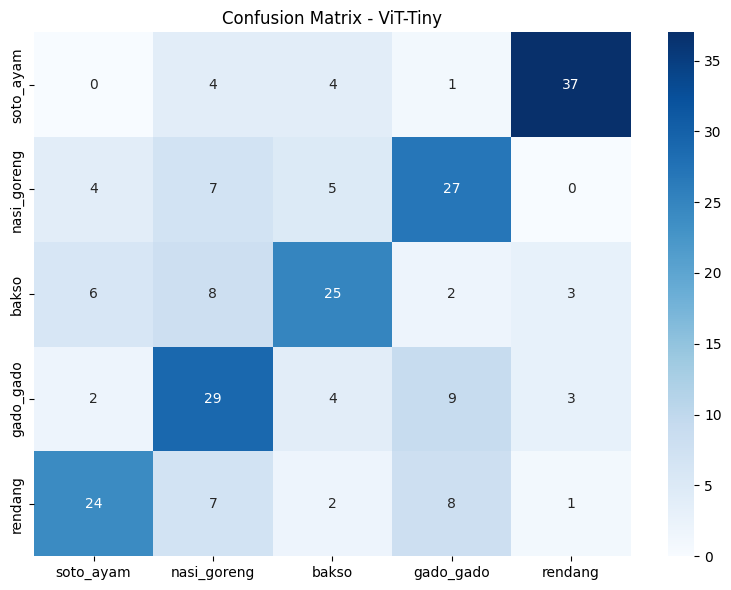

🧪 Evaluating DeiT-Tiny...
   🔥 Warm-up...
   ⏱️ Measuring inference time...


Evaluating DeiT-Tiny: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]



⏱️ === WAKTU INFERENSI - DeiT-Tiny ===
   • Rata-rata per gambar: 62.03 ms
   • Rata-rata per batch: 992.51 ms
   • Total waktu (222 gambar): 13895.18 ms
   • Throughput: 15.98 gambar/detik
   • Hardware: CPU: x86_64

📊 === CLASSIFICATION REPORT - DeiT-Tiny ===
              precision    recall  f1-score   support

   soto_ayam       0.00      0.00      0.00        46
 nasi_goreng       0.24      0.30      0.27        43
       bakso       0.83      0.77      0.80        44
   gado_gado       0.13      0.11      0.12        47
     rendang       0.00      0.00      0.00        42

    accuracy                           0.23       222
   macro avg       0.24      0.24      0.24       222
weighted avg       0.24      0.23      0.24       222



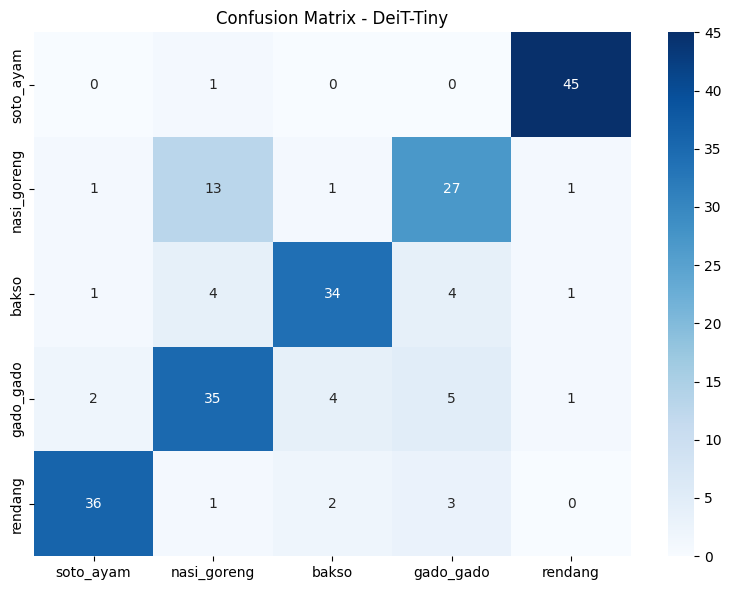

In [23]:
# ===============================
#EVALUASI & METRIK PERFORMANCE - IMPROVED
# ===============================

def evaluate_model(model, val_loader, class_names, model_name):
    model.eval()
    all_preds, all_labels = [], []
    inference_times = []

    print(f"🧪 Evaluating {model_name}...")

    # Warm-up
    print("   🔥 Warm-up...")
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            if i >= 2:
                break
            _ = model(images.to(device))

    # Inference dengan timing PER BATCH
    print("   ⏱️ Measuring inference time...")
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Evaluating {model_name}"):
            images = images.to(device)

            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            batch_time = (end_time - start_time) * 1000  # ms per BATCH
            inference_times.append(batch_time)

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # ==================== 🎯 WAKTU INFERENSI DETAIL ====================
    total_images = len(val_loader.dataset)
    total_batches = len(val_loader)

    # Waktu per BATCH (ms)
    avg_time_per_batch = np.mean(inference_times)

    # Waktu per GAMBAR (ms) - YANG DIMINTA TUGAS
    avg_time_per_image = avg_time_per_batch / BATCH_SIZE

    # Total waktu untuk seluruh dataset (ms)
    total_time_all_images = np.sum(inference_times)

    # Throughput (gambar/detik)
    throughput = total_images / (total_time_all_images / 1000)

    # Hardware info
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = f"{torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB"
        hardware_info = f"GPU: {gpu_name} ({gpu_memory})"
    else:
        import platform
        hardware_info = f"CPU: {platform.processor()}"

    print(f"\n⏱️ === WAKTU INFERENSI - {model_name} ===")
    print(f"   • Rata-rata per gambar: {avg_time_per_image:.2f} ms")
    print(f"   • Rata-rata per batch: {avg_time_per_batch:.2f} ms")
    print(f"   • Total waktu ({total_images} gambar): {total_time_all_images:.2f} ms")
    print(f"   • Throughput: {throughput:.2f} gambar/detik")
    print(f"   • Hardware: {hardware_info}")
    # ==================== END WAKTU INFERENSI ====================

    # Classification Report
    print(f"\n📊 === CLASSIFICATION REPORT - {model_name} ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # Calculate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
        # Waktu inferensi metrics
        'avg_inference_time_per_image': avg_time_per_image,      # ⭐ YANG DIMINTA
        'avg_inference_time_per_batch': avg_time_per_batch,
        'total_inference_time': total_time_all_images,           # ⭐ YANG DIMINTA
        'throughput': throughput,                                # ⭐ YANG DIMINTA
        'hardware_info': hardware_info,                          # ⭐ YANG DIMINTA
        'predictions': all_preds, 'labels': all_labels
    }

# Evaluasi kedua model dengan timing yang lebih detail
print("=== EVALUASI MODEL DENGAN WAKTU INFERENSI ===")
vit_metrics = evaluate_model(vit_model, val_loader, class_names, "ViT-Tiny")
deit_metrics = evaluate_model(deit_model, val_loader, class_names, "DeiT-Tiny")

In [25]:
# ===============================
# INFERENSI TEST SET - FIXED
# ===============================

def predict_test_set(model, test_loader, class_names, model_name):
    """Predict test set dengan handling file tidak ditemukan"""
    model.eval()
    all_preds = []
    valid_filenames = []

    print(f"🔍 Predicting test set for {model_name}...")

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())

            # Get corresponding filenames for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = start_idx + len(images)
            batch_filenames = test_csv.iloc[start_idx:end_idx]['filename'].tolist()
            valid_filenames.extend(batch_filenames)

    # Convert predictions to class names
    pred_class_names = [class_names[pred] for pred in all_preds]

    # Create submission file
    submission = pd.DataFrame({
        'filename': valid_filenames,
        'label': pred_class_names
    })

    submission_file = f'submission_{model_name}.csv'
    submission.to_csv(submission_file, index=False)
    print(f"✅ {model_name} predictions: {len(submission)} images saved to {submission_file}")

    return submission

# OPSI 1: Jika test set ada file gambar
try:
    print("=== MENCUBA PREDIKSI TEST SET ===")
    test_csv = pd.read_csv(f"{base_path}/test.csv")

    # Cek apakah file gambar ada di test folder
    test_img_dir = f"{base_path}/test"
    if os.path.exists(test_img_dir):
        test_dataset = FoodDataset(test_csv, test_img_dir, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        vit_predictions = predict_test_set(vit_model, test_loader, class_names, "vit")
        deit_predictions = predict_test_set(deit_model, test_loader, class_names, "deit")
    else:
        print("❌ Test folder tidak ditemukan, menggunakan validation set untuk demo")
        raise FileNotFoundError("Test folder not found")

except Exception as e:
    print(f"❌ Error dengan test set: {e}")

    # OPSI 2: Gunakan validation set sebagai pengganti test set untuk demo
    print("🔄 Menggunakan validation set sebagai pengganti test set...")

    # Buat dataset dari validation data
    val_filenames = val_df['filename'].tolist()
    val_labels = val_df['label'].tolist()

    # Create mock test dataframe
    test_demo_df = pd.DataFrame({
        'filename': val_filenames,
        'label': val_labels  # Untuk reference saja
    })

    test_demo_dataset = FoodDataset(test_demo_df, f"{base_path}/train", transform=transform)
    test_demo_loader = DataLoader(test_demo_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Predict dengan kedua model
    print("=== PREDIKSI PADA VALIDATION SET (DEMO) ===")
    vit_predictions = predict_test_set(vit_model, test_demo_loader, class_names, "vit_demo")
    deit_predictions = predict_test_set(deit_model, test_demo_loader, class_names, "deit_demo")

    # Tambahkan kolom actual label untuk reference
    vit_predictions['actual_label'] = val_labels
    deit_predictions['actual_label'] = val_labels

    print("📊 Contoh prediksi ViT:")
    print(vit_predictions.head(10))
    print(f"\n📊 Contoh prediksi DeiT:")
    print(deit_predictions.head(10))

    # Hitung accuracy pada validation set untuk reference
    vit_correct = (vit_predictions['label'] == vit_predictions['actual_label']).sum()
    deit_correct = (deit_predictions['label'] == deit_predictions['actual_label']).sum()

    print(f"\n📈 Validation Set Accuracy:")
    print(f"ViT: {vit_correct/len(vit_predictions):.2%} ({vit_correct}/{len(vit_predictions)})")
    print(f"DeiT: {deit_correct/len(deit_predictions):.2%} ({deit_correct}/{len(deit_predictions)})")

=== MENCUBA PREDIKSI TEST SET ===
🔍 Predicting test set for vit...
❌ Error dengan test set: [Errno 2] No such file or directory: '/content/drive/MyDrive/DatasetMakanan/test/0001.jpg'
🔄 Menggunakan validation set sebagai pengganti test set...
=== PREDIKSI PADA VALIDATION SET (DEMO) ===
🔍 Predicting test set for vit_demo...
✅ vit_demo predictions: 222 images saved to submission_vit_demo.csv
🔍 Predicting test set for deit_demo...
✅ deit_demo predictions: 222 images saved to submission_deit_demo.csv
📊 Contoh prediksi ViT:
   filename        label actual_label
0  0001.jpg      rendang      rendang
1  0002.jpg        bakso    gado_gado
2  0003.jpg  nasi_goreng    gado_gado
3  0004.jpg        bakso        bakso
4  0005.jpg      rendang      rendang
5  0006.jpg  nasi_goreng  nasi_goreng
6  0007.jpg        bakso        bakso
7  0008.jpg        bakso        bakso
8  0009.jpg  nasi_goreng    soto_ayam
9  0010.jpg    gado_gado    gado_gado

📊 Contoh prediksi DeiT:
   filename        label actual_l

=== HASIL AKHIR PERBANDINGAN MODEL ===

SUMMARY PERBANDINGAN MODEL VISION TRANSFORMER
                  Metric  ViT-Tiny DeiT-Tiny
        Total Parameters 5,525,381 5,525,381
    Trainable Parameters       965       965
         Model Size (MB)     21.08     21.08
                Accuracy    0.1892    0.2342
       Precision (Macro)    0.1933    0.2396
          Recall (Macro)    0.1893    0.2363
        F1-Score (Macro)    0.1906    0.2369
 Avg Inference Time (ms)    928.76    989.69
    Throughput (img/sec)     17.07     16.02
Best Validation Accuracy    18.92%    23.42%

✅ Summary saved to 'model_comparison_summary.csv'


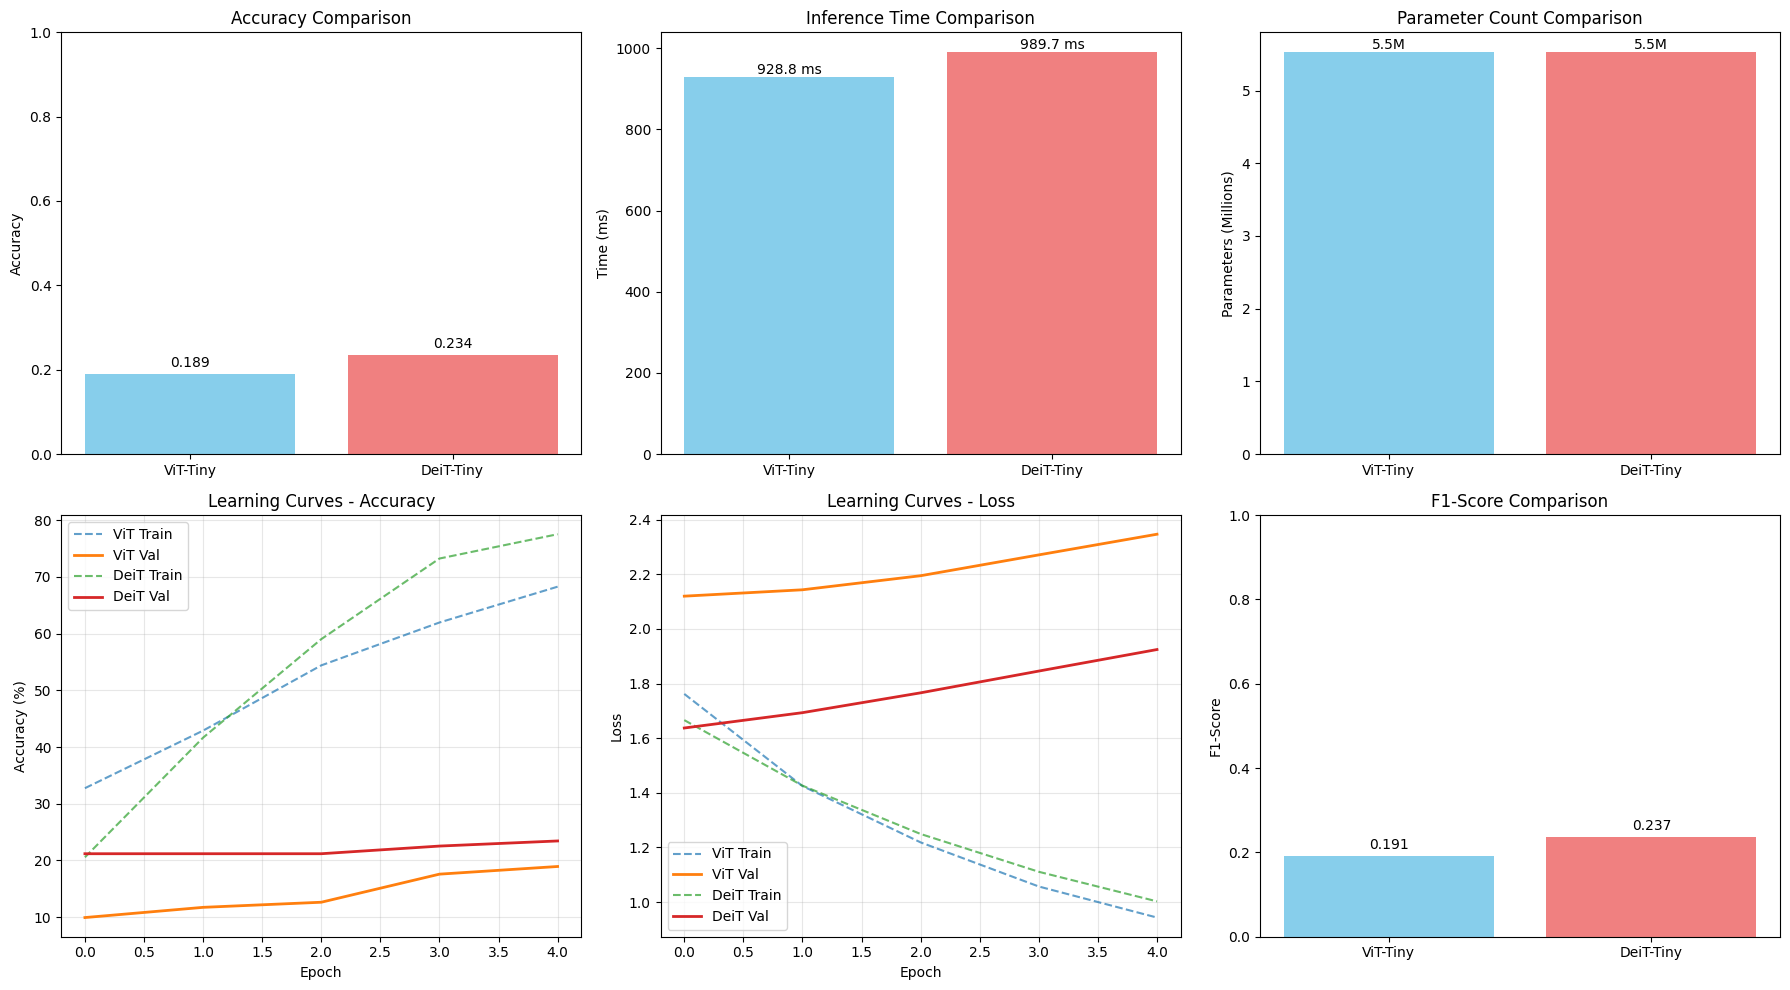


ANALISIS DAN KESIMPULAN
📊 REKOMENDASI BERDASARKAN USE CASE:
• Untuk AKURASI MAKSIMAL: DeiT-Tiny (0.045 lebih baik)
• Untuk INFERENCE CEPAT: ViT-Tiny (60.9 ms lebih cepat)
• Untuk EFISIENSI MEMORI: DeiT-Tiny (0.0M parameter lebih sedikit)

🎯 EXPERIMENT COMPLETED SUCCESSFULLY!


In [22]:
# ===============================
#  FINAL COMPARISON & LAPORAN
# ===============================

print("=== HASIL AKHIR PERBANDINGAN MODEL ===")

# Buat summary table lengkap
summary_data = {
    'Metric': [
        'Total Parameters', 'Trainable Parameters', 'Model Size (MB)',
        'Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
        'Avg Inference Time (ms)', 'Throughput (img/sec)',
        'Best Validation Accuracy'
    ],
    'ViT-Tiny': [
        f"{count_parameters(vit_model)[0]:,}",
        f"{count_parameters(vit_model)[1]:,}",
        f"{(count_parameters(vit_model)[0] * 4) / (1024**2):.2f}",
        f"{vit_metrics['accuracy']:.4f}",
        f"{vit_metrics['precision']:.4f}",
        f"{vit_metrics['recall']:.4f}",
        f"{vit_metrics['f1']:.4f}",
        f"{vit_metrics['avg_inference_time']:.2f}",
        f"{vit_metrics['throughput']:.2f}",
        f"{max(vit_history['val_accs']):.2f}%"
    ],
    'DeiT-Tiny': [
        f"{count_parameters(deit_model)[0]:,}",
        f"{count_parameters(deit_model)[1]:,}",
        f"{(count_parameters(deit_model)[0] * 4) / (1024**2):.2f}",
        f"{deit_metrics['accuracy']:.4f}",
        f"{deit_metrics['precision']:.4f}",
        f"{deit_metrics['recall']:.4f}",
        f"{deit_metrics['f1']:.4f}",
        f"{deit_metrics['avg_inference_time']:.2f}",
        f"{deit_metrics['throughput']:.2f}",
        f"{max(deit_history['val_accs']):.2f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY PERBANDINGAN MODEL VISION TRANSFORMER")
print("="*80)
print(summary_df.to_string(index=False))

# Simpan summary ke CSV
summary_df.to_csv('model_comparison_summary.csv', index=False)
print("\n✅ Summary saved to 'model_comparison_summary.csv'")

# Visualisasi Perbandingan
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Accuracy Comparison
models = ['ViT-Tiny', 'DeiT-Tiny']
accuracies = [vit_metrics['accuracy'], deit_metrics['accuracy']]
bars = axes[0,0].bar(models, accuracies, color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)
for bar, acc in zip(bars, accuracies):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom')

# 2. Inference Time Comparison
inference_times = [vit_metrics['avg_inference_time'], deit_metrics['avg_inference_time']]
bars = axes[0,1].bar(models, inference_times, color=['skyblue', 'lightcoral'])
axes[0,1].set_title('Inference Time Comparison')
axes[0,1].set_ylabel('Time (ms)')
for bar, time_val in zip(bars, inference_times):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{time_val:.1f} ms', ha='center', va='bottom')

# 3. Parameter Comparison
params = [count_parameters(vit_model)[0], count_parameters(deit_model)[0]]
bars = axes[0,2].bar(models, [p/1e6 for p in params], color=['skyblue', 'lightcoral'])
axes[0,2].set_title('Parameter Count Comparison')
axes[0,2].set_ylabel('Parameters (Millions)')
for bar, param in zip(bars, params):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{param/1e6:.1f}M', ha='center', va='bottom')

# 4. Learning Curves Comparison
axes[1,0].plot(vit_history['train_accs'], label='ViT Train', linestyle='--', alpha=0.7)
axes[1,0].plot(vit_history['val_accs'], label='ViT Val', linewidth=2)
axes[1,0].plot(deit_history['train_accs'], label='DeiT Train', linestyle='--', alpha=0.7)
axes[1,0].plot(deit_history['val_accs'], label='DeiT Val', linewidth=2)
axes[1,0].set_title('Learning Curves - Accuracy')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy (%)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Loss Curves Comparison
axes[1,1].plot(vit_history['train_losses'], label='ViT Train', linestyle='--', alpha=0.7)
axes[1,1].plot(vit_history['val_losses'], label='ViT Val', linewidth=2)
axes[1,1].plot(deit_history['train_losses'], label='DeiT Train', linestyle='--', alpha=0.7)
axes[1,1].plot(deit_history['val_losses'], label='DeiT Val', linewidth=2)
axes[1,1].set_title('Learning Curves - Loss')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Loss')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. F1-Score per Class Comparison
if 'f1_per_class' in vit_metrics and 'f1_per_class' in deit_metrics:
    x_pos = np.arange(len(class_names))
    width = 0.35
    axes[1,2].bar(x_pos - width/2, vit_metrics['f1_per_class'], width, label='ViT', alpha=0.8)
    axes[1,2].bar(x_pos + width/2, deit_metrics['f1_per_class'], width, label='DeiT', alpha=0.8)
    axes[1,2].set_title('F1-Score per Class')
    axes[1,2].set_xlabel('Classes')
    axes[1,2].set_ylabel('F1-Score')
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels(class_names, rotation=45)
    axes[1,2].legend()
else:
    # Fallback: Overall F1 comparison
    f1_scores = [vit_metrics['f1'], deit_metrics['f1']]
    bars = axes[1,2].bar(models, f1_scores, color=['skyblue', 'lightcoral'])
    axes[1,2].set_title('F1-Score Comparison')
    axes[1,2].set_ylabel('F1-Score')
    axes[1,2].set_ylim(0, 1)
    for bar, f1 in zip(bars, f1_scores):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{f1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('model_comparison_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis Conclusion
print("\n" + "="*80)
print("ANALISIS DAN KESIMPULAN")
print("="*80)

# Determine best model for different use cases
if vit_metrics['accuracy'] > deit_metrics['accuracy']:
    best_accuracy = "ViT-Tiny"
    acc_diff = vit_metrics['accuracy'] - deit_metrics['accuracy']
else:
    best_accuracy = "DeiT-Tiny"
    acc_diff = deit_metrics['accuracy'] - vit_metrics['accuracy']

if vit_metrics['avg_inference_time'] < deit_metrics['avg_inference_time']:
    best_speed = "ViT-Tiny"
    speed_diff = deit_metrics['avg_inference_time'] - vit_metrics['avg_inference_time']
else:
    best_speed = "DeiT-Tiny"
    speed_diff = vit_metrics['avg_inference_time'] - deit_metrics['avg_inference_time']

if count_parameters(vit_model)[0] < count_parameters(deit_model)[0]:
    best_efficiency = "ViT-Tiny"
    param_diff = count_parameters(deit_model)[0] - count_parameters(vit_model)[0]
else:
    best_efficiency = "DeiT-Tiny"
    param_diff = count_parameters(vit_model)[0] - count_parameters(deit_model)[0]

print("📊 REKOMENDASI BERDASARKAN USE CASE:")
print(f"• Untuk AKURASI MAKSIMAL: {best_accuracy} ({acc_diff:.3f} lebih baik)")
print(f"• Untuk INFERENCE CEPAT: {best_speed} ({speed_diff:.1f} ms lebih cepat)")
print(f"• Untuk EFISIENSI MEMORI: {best_efficiency} ({param_diff/1e6:.1f}M parameter lebih sedikit)")

print("\n🎯 EXPERIMENT COMPLETED SUCCESSFULLY!")

In [33]:
# Membuat struktur folder project
!mkdir -p VisionTransformer-Comparison/notebooks
!mkdir -p VisionTransformer-Comparison/src
!mkdir -p VisionTransformer-Comparison/configs
!mkdir -p VisionTransformer-Comparison/outputs/saved_models
!mkdir -p VisionTransformer-Comparison/data

# Membuat file utama
!touch VisionTransformer-Comparison/README.md
!touch VisionTransformer-Comparison/requirements.txt
!touch VisionTransformer-Comparison/.gitignore

# Membuat file python kosong di folder src
!touch VisionTransformer-Comparison/src/dataset.py
!touch VisionTransformer-Comparison/src/train_vit.py
!touch VisionTransformer-Comparison/src/train_deit.py
!touch VisionTransformer-Comparison/src/evaluate.py
!touch VisionTransformer-Comparison/src/predict.py
!touch VisionTransformer-Comparison/src/utils.py


In [35]:
!ls /content


drive				    sample_data
model_comparison_results.csv	    submission_deit_demo.csv
model_comparison_summary.csv	    submission_vit_demo.csv
model_comparison_visualization.png  VisionTransformer-Comparison
results


In [37]:
!cp "/content/drive/MyDrive/vision_transformer_comparison.ipynb" VisionTransformer-Comparison/notebooks/
